In [1]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
# Importamos utilidades y modelos de sklearn
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import category_encoders as ce

In [2]:
dtypes = {'id': 'int32', 
'titulo': 'object', 
'descripcion': 'object', 
'tipodepropiedad': 'category', 
'direccion': 'object', 
'ciudad': 'object', 
'provincia': 'category', 
'antiguedad': 'float', 
'habitaciones': 'float', 
'garages': 'float', 
'banos': 'float', 
'metroscubiertos': 'float', 
'metrostotales': 'float', 
'idzona': 'object', 
'lat': 'float64', 
'lng': 'float64', 
'gimnasio': 'float', 
'usosmultiples': 'float', 
'piscina': 'float', 
'escuelascercanas': 'float', 
'centroscomercialescercanos': 'float', 
'precio': 'float', }

data = pd.read_csv("train.csv", dtype = dtypes)
data.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,...,23533.0,NaN,NaN,2015-08-23 00:00:00,0.0,0.0,0.0,0.0,0.0,2273000.0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,...,24514.0,19.310205,-99.227655,2013-06-28 00:00:00,0.0,0.0,0.0,1.0,1.0,3600000.0
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,...,48551.0,NaN,NaN,2015-10-17 00:00:00,0.0,0.0,0.0,0.0,0.0,1200000.0
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,...,53666.0,19.301890,-99.688015,2012-03-09 00:00:00,0.0,0.0,0.0,1.0,1.0,650000.0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,...,47835.0,NaN,NaN,2016-06-07 00:00:00,0.0,0.0,0.0,0.0,0.0,1150000.0


# Pre-procesamiento de data

In [3]:
data["ciudad"].nunique()

875

In [4]:
data.isnull().sum()

id                                 0
titulo                          5387
descripcion                     1619
tipodepropiedad                   46
direccion                      53072
ciudad                           372
provincia                        155
antiguedad                     43555
habitaciones                   22471
garages                        37765
banos                          26221
metroscubiertos                17400
metrostotales                  51467
idzona                         28621
lat                           123488
lng                           123488
fecha                              0
gimnasio                           0
usosmultiples                      0
piscina                            0
escuelascercanas                   0
centroscomercialescercanos         0
precio                             0
dtype: int64

In [5]:
data.isnull().sum().sum()

535127

In [6]:
data.size

5520000

In [7]:
(data.isnull().sum().sum()/(data.size))*100

9.694329710144928

Los Nulls representan el 10% de los datos.

# CON XGBOOST NO HACE FALTA PREOCUPARSE POR LOS NULLs

# Levanto el csv de test para calcularle los features en paralelo

In [8]:
test = pd.read_csv("test.csv", dtype = dtypes)
test.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos
0,4941,"casa en venta en miguel hidalgo, distrito federal",<p>excelente casa estilo moderno.</p>,Casa,Bosque de Cedros,Miguel Hidalgo,Distrito Federal,29.0,3.0,NaN,...,NaN,NaN,19.408668,-99.246767,2013-07-20 00:00:00,0.0,0.0,0.0,0.0,0.0
1,51775,departamentos en venta en montebello,<p>departamento una recamara:\n</p><p>departam...,Apartamento,NaN,Mérida,Yucatán,NaN,1.0,1.0,...,67.0,113851.0,21.032480,-89.592424,2015-10-24 00:00:00,0.0,0.0,0.0,0.0,0.0
2,115253,departamento nuevo delegación coyoacán de 87 m...,"departamento nuevo de 87.06 m2, 1 cajón de est...",Apartamento,"Pueblo de los Reyes, Coyoacán, Mexico D.F.",Coyoacán,Distrito Federal,0.0,2.0,1.0,...,100.0,23620.0,19.332829,-99.152913,2015-05-30 00:00:00,0.0,0.0,0.0,0.0,1.0
3,299321,departamento en venta en acapulco,<p> raíces dv001 precioso departamento tipo k...,Apartamento,NaN,Acapulco de Juárez,Guerrero,2.0,2.0,2.0,...,86.0,129347.0,16.860487,-99.878383,2015-04-02 00:00:00,0.0,0.0,0.0,0.0,0.0
4,173570,bonita casa sola equipada de dos niveles en lo...,"<p>casa sola, bonita de dos rec&aacute;maras u...",Casa,CEDROS,Tultitlán,Edo. de México,10.0,2.0,1.0,...,76.0,57125.0,19.640482,-99.127273,2013-08-15 00:00:00,0.0,0.0,0.0,1.0,1.0


In [9]:
len(test)

60000

# Preparacion del set de datos de entrenamiento (features)

La idea es preparar el set con los datos para exportar y que despues el modelo simplemente levante, separe en set de entrenamiento y test, entrene y devuelva una prediccion.

Se procede a calcular features. Cada feature se agregara al DataFrame final que tendra que levantar despues el modelo. Ojo que dentro de este DataFrame tambien va a estar el precio (que es el label).

In [10]:
train_set = pd.DataFrame()

In [11]:
test_set = pd.DataFrame()

# Agrego las columnas que ya se encuentran

In [12]:
data.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

# Set columnas para 'train_set'

In [13]:
train_cols = ['id','antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio','provincia','ciudad']

In [14]:
train_set = data.loc[:, train_cols]

In [15]:
train_set.head()

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,provincia,ciudad
0,254099,NaN,2.0,1.0,2.0,80.0,80.0,23533.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2273000.0,Distrito Federal,Benito Juárez
1,53461,10.0,3.0,2.0,2.0,268.0,180.0,24514.0,19.310205,-99.227655,0.0,0.0,0.0,1.0,1.0,3600000.0,Distrito Federal,La Magdalena Contreras
2,247984,5.0,3.0,2.0,2.0,144.0,166.0,48551.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1200000.0,Jalisco,Tonalá
3,209067,1.0,2.0,1.0,1.0,63.0,67.0,53666.0,19.301890,-99.688015,0.0,0.0,0.0,1.0,1.0,650000.0,Edo. de México,Zinacantepec
4,185997,10.0,2.0,1.0,1.0,95.0,95.0,47835.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1150000.0,Jalisco,Zapopan


# Set columnas para 'test_set'

In [16]:
test_cols = ['id', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos','provincia','ciudad']

In [17]:
# Se mete en test_set la columna 'id'; recordar de luego sacarla!
test_set = test.loc[:, test_cols]

In [18]:
test_set.head()

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,provincia,ciudad
0,4941,29.0,3.0,NaN,4.0,300.0,NaN,NaN,19.408668,-99.246767,0.0,0.0,0.0,0.0,0.0,Distrito Federal,Miguel Hidalgo
1,51775,NaN,1.0,1.0,1.0,67.0,67.0,113851.0,21.032480,-89.592424,0.0,0.0,0.0,0.0,0.0,Yucatán,Mérida
2,115253,0.0,2.0,1.0,2.0,87.0,100.0,23620.0,19.332829,-99.152913,0.0,0.0,0.0,0.0,1.0,Distrito Federal,Coyoacán
3,299321,2.0,2.0,2.0,2.0,86.0,86.0,129347.0,16.860487,-99.878383,0.0,0.0,0.0,0.0,0.0,Guerrero,Acapulco de Juárez
4,173570,10.0,2.0,1.0,1.0,80.0,76.0,57125.0,19.640482,-99.127273,0.0,0.0,0.0,1.0,1.0,Edo. de México,Tultitlán


# Se codifica el tipo de propiedad

In [19]:
data['train'] = True
test['train'] = False
combined = pd.concat([data, test], sort = True)

In [20]:
len(combined)

300000

In [21]:
var_categoricas = ['tipodepropiedad']

In [22]:
one_hot_enc = ce.OneHotEncoder(handle_unknown = 'ignore')
one_hot_encoded = one_hot_enc.fit_transform(combined[var_categoricas])
one_hot_encoded.columns

Index(['tipodepropiedad_1', 'tipodepropiedad_2', 'tipodepropiedad_3',
       'tipodepropiedad_4', 'tipodepropiedad_5', 'tipodepropiedad_6',
       'tipodepropiedad_7', 'tipodepropiedad_8', 'tipodepropiedad_9',
       'tipodepropiedad_10', 'tipodepropiedad_11', 'tipodepropiedad_12',
       'tipodepropiedad_13', 'tipodepropiedad_14', 'tipodepropiedad_15',
       'tipodepropiedad_16', 'tipodepropiedad_17', 'tipodepropiedad_18',
       'tipodepropiedad_19', 'tipodepropiedad_20', 'tipodepropiedad_21',
       'tipodepropiedad_22', 'tipodepropiedad_23', 'tipodepropiedad_24',
       'tipodepropiedad_25'],
      dtype='object')

In [23]:
combined.columns

Index(['antiguedad', 'banos', 'centroscomercialescercanos', 'ciudad',
       'descripcion', 'direccion', 'escuelascercanas', 'fecha', 'garages',
       'gimnasio', 'habitaciones', 'id', 'idzona', 'lat', 'lng',
       'metroscubiertos', 'metrostotales', 'piscina', 'precio', 'provincia',
       'tipodepropiedad', 'titulo', 'train', 'usosmultiples'],
      dtype='object')

In [24]:
combined = pd.concat([combined, one_hot_encoded], axis = 1)
len(combined)

300000

In [25]:
combined.columns

Index(['antiguedad', 'banos', 'centroscomercialescercanos', 'ciudad',
       'descripcion', 'direccion', 'escuelascercanas', 'fecha', 'garages',
       'gimnasio', 'habitaciones', 'id', 'idzona', 'lat', 'lng',
       'metroscubiertos', 'metrostotales', 'piscina', 'precio', 'provincia',
       'tipodepropiedad', 'titulo', 'train', 'usosmultiples',
       'tipodepropiedad_1', 'tipodepropiedad_2', 'tipodepropiedad_3',
       'tipodepropiedad_4', 'tipodepropiedad_5', 'tipodepropiedad_6',
       'tipodepropiedad_7', 'tipodepropiedad_8', 'tipodepropiedad_9',
       'tipodepropiedad_10', 'tipodepropiedad_11', 'tipodepropiedad_12',
       'tipodepropiedad_13', 'tipodepropiedad_14', 'tipodepropiedad_15',
       'tipodepropiedad_16', 'tipodepropiedad_17', 'tipodepropiedad_18',
       'tipodepropiedad_19', 'tipodepropiedad_20', 'tipodepropiedad_21',
       'tipodepropiedad_22', 'tipodepropiedad_23', 'tipodepropiedad_24',
       'tipodepropiedad_25'],
      dtype='object')

In [26]:
train_set = train_set.merge(combined.loc[:, ['tipodepropiedad_1', 'tipodepropiedad_2', 'tipodepropiedad_3',
       'tipodepropiedad_4', 'tipodepropiedad_5', 'tipodepropiedad_6',
       'tipodepropiedad_7', 'tipodepropiedad_8', 'tipodepropiedad_9',
       'tipodepropiedad_10', 'tipodepropiedad_11', 'tipodepropiedad_12',
       'tipodepropiedad_13', 'tipodepropiedad_14', 'tipodepropiedad_15',
       'tipodepropiedad_16', 'tipodepropiedad_17', 'tipodepropiedad_18',
       'tipodepropiedad_19', 'tipodepropiedad_20', 'tipodepropiedad_21',
       'tipodepropiedad_22', 'tipodepropiedad_23', 'tipodepropiedad_24',
       'tipodepropiedad_25', 'id']], on='id', how = 'left')

In [27]:
test_set = test_set.merge(combined.loc[:, ['tipodepropiedad_1', 'tipodepropiedad_2', 'tipodepropiedad_3',
       'tipodepropiedad_4', 'tipodepropiedad_5', 'tipodepropiedad_6',
       'tipodepropiedad_7', 'tipodepropiedad_8', 'tipodepropiedad_9',
       'tipodepropiedad_10', 'tipodepropiedad_11', 'tipodepropiedad_12',
       'tipodepropiedad_13', 'tipodepropiedad_14', 'tipodepropiedad_15',
       'tipodepropiedad_16', 'tipodepropiedad_17', 'tipodepropiedad_18',
       'tipodepropiedad_19', 'tipodepropiedad_20', 'tipodepropiedad_21',
       'tipodepropiedad_22', 'tipodepropiedad_23', 'tipodepropiedad_24',
       'tipodepropiedad_25', 'id']], on='id', how = 'left')

In [28]:
len(train_set)

240000

In [29]:
len(test_set)

60000

# Nuevos features

## OJO!!! Pensar muy bien si tiene sentido agregar ese feature o no... Porque agregar de más puede ser muy malo a priori. Lo más simple suele ser lo mejor!!!

## Fecha de publicación

In [30]:
data['fecha'] = pd.to_datetime(data['fecha'])
data['anio'] = data['fecha'].dt.year

In [31]:
data['anio'].value_counts()

2016    94038
2015    51470
2014    40572
2013    30386
2012    23534
Name: anio, dtype: int64

In [32]:
train_set['anio_publ'] = data['anio']

In [33]:
test_set['anio_publ'] = pd.to_datetime(test['fecha']).dt.year

### Feature: correlacion precio vs provincia

In [34]:
dfgp = data.dropna(subset = ['garages']).groupby(['provincia'])['garages', 'precio'].corr().reset_index()
dfgp.rename(columns={'precio':'corr_p'},inplace=True)
dfgp = dfgp[ dfgp['level_1'] == 'garages']
dfgp.sort_values(['corr_p'], ascending = False, inplace = True)
dfgp

,provincia,level_1,garages,corr_p
20,Edo. de México,garages,1.0,0.488388
16,Distrito Federal,garages,1.0,0.420996
40,Puebla,garages,1.0,0.409616
42,Querétaro,garages,1.0,0.406326
32,Morelos,garages,1.0,0.385426
54,Tamaulipas,garages,1.0,0.376455
28,Jalisco,garages,1.0,0.367878
46,San luis Potosí,garages,1.0,0.366338
44,Quintana Roo,garages,1.0,0.358196
12,Coahuila,garages,1.0,0.356403


In [35]:
train_set = train_set.merge(dfgp[['provincia','corr_p']], on = 'provincia', how = 'left')
test_set = test_set.merge(dfgp[['provincia','corr_p']], on = 'provincia', how = 'left')

### Feature: correlacion garage vs precio por ciudad

In [36]:
dfgpc = data
dfgpc['n'] = 1
dfgpc = dfgpc.groupby(['ciudad']).filter(lambda x: x['n'].sum() >= 500)
dfgpc['ciudad'].value_counts()

Querétaro                12646
Benito Juárez            11014
Zapopan                  10360
San Luis Potosí           7925
Mérida                    7162
Monterrey                 6946
Alvaro Obregón            6633
Cuauhtémoc                6614
Naucalpan de Juárez       6554
Miguel Hidalgo            5795
Atizapán de Zaragoza      5783
Tlalpan                   5721
Huixquilucan              5718
Coyoacán                  5293
Puebla                    4636
Guadalajara               4006
San Andrés Cholula        3805
Cancún                    3779
Cuernavaca                3775
Chihuahua                 3757
Tlalnepantla de Baz       3588
Cuautitlán Izcalli        3408
Tlajomulco de Zúñiga      3254
Gustavo A. Madero         3141
Iztapalapa                3093
Cuajimalpa de Morelos     3020
Tijuana                   2863
Hermosillo                2590
Acapulco de Juárez        2454
Ecatepec de Morelos       2159
                         ...  
San Pedro Cholula         1029
Tultitlá

In [37]:
dfgpc = dfgpc.dropna(subset = ['garages']).groupby(['ciudad'])['garages', 'precio'].corr().reset_index()
dfgpc = dfgpc[ dfgpc['level_1'] == 'garages']
dfgpc.sort_values(['precio'], ascending = False, inplace = True)
dfgpc.rename(columns={'precio':'corr_p_gar_ciu'},inplace=True)

Text(0, 0.5, 'ciudad')

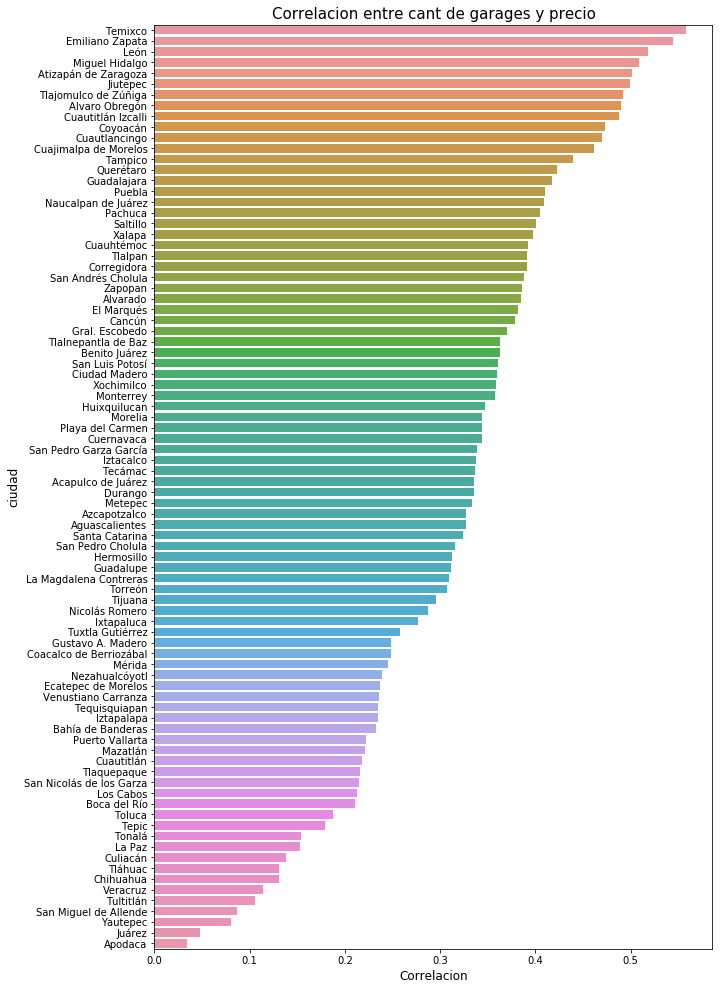

In [38]:
plt.figure(figsize=(10,17))
g = sns.barplot(x = dfgpc['corr_p_gar_ciu'], y = dfgpc['ciudad'])
g.set_title("Correlacion entre cant de garages y precio", fontsize=15)
g.set_xlabel("Correlacion", fontsize=12)
g.set_ylabel("ciudad", fontsize=12)

In [39]:
train_set = train_set.merge(dfgpc[['ciudad','corr_p_gar_ciu']], on = 'ciudad', how = 'left')
test_set = test_set.merge(dfgpc[['ciudad','corr_p_gar_ciu']], on = 'ciudad', how = 'left')

### Feature: según la descripción

In [349]:
dfdesc = data

In [348]:
def is_nan(x):
    return (x is np.nan or x != x)

In [347]:
def count_word_desc(desc):
    res = []
    if(is_nan(desc)):
        return [('',0)]  
    for word in str(desc).split(' '):
        if(len(word) > 4):
            res.append((word,1))
    return res

In [353]:
def desc_word_max(row):
    global i_count_word_max
    print("it... "+str(i_count_word_max))
    i_count = i_count + 1
    res = count_word_desc(row['descripcion'])
    if(len(res) == 0):
        return "0"
    #print("Test "+str(res))
    df = pd.DataFrame(res)
    #print(df)
    #print('flag1')
    df.rename(columns={0:'word',1:'count'},inplace=True)
    #print('aca2')
    df = df.groupby(by='word').sum().sort_values('count',ascending=False).reset_index()
    #print('flag2')
    #df = gdf.sum().sort_values('count',ascending=False).reset_index()
    #print('flag4')
    #print(df)
    r_word = str(df['word'][0]) + "_" + str(df['count'][0])
    return r_word
    #return r_word #+ str(df.head(1)['count'])
    #return -1

## OJO! Demora mucho tiempo!

In [354]:
i_count_word_max = 0
dfdesc['word_count'] = dfdesc.apply(desc_word_max,axis=1)

,id,word_count,precio
174276,153761,vista_2,12525000.0
209858,181271,"acabados,_1",12521000.0
81715,64975,recámara_2,12520000.0
192956,279973,niveles_2,12516000.0
232457,165404,adquirir_2,12515000.0


In [356]:
df_desc_count = dfdesc[['id','word_count','precio']].sort_values(by='precio',ascending=False).reset_index()

In [357]:
df_desc_count.to_csv("df_desc_count.csv", index = False)

In [108]:
#res = []
#for word in data['descripcion'][2].split(' '):
#    if(len(word) > 4):
#        res.append((word,1))
#df = pd.DataFrame(res)

In [118]:
#df.rename(columns={0:'word',1:'count'},inplace=True)
#df.groupby(by='word').sum().reset_index().sort_values('count',ascending=False)

### Feature: total de antiguedad por anio

In [40]:
# data.transpose()

In [41]:
# ant = data
# ant['count'] = 1
# ant = ant.groupby(by='antiguedad').sum()[['count','habitaciones','id']]
#ant.sort_values(ascending=False).tail(5)
# ant = ant.reset_index()
# ant.head()

In [42]:
# def hab_ant(row):
#     if(row['antiguedad'] <= 10 ):
#         return row['count'] * 1
#     return row['habitaciones'] * 0.5

In [43]:
# ant2 = ant
# ant2['c_hab_ant'] = ant2.apply(hab_ant,axis=1)
# ant2.head(15)

In [44]:
# data = data.drop(columns='count')

In [45]:
# ant3 = ant2[['c_hab_ant','antiguedad']]
# ant3.head()

In [46]:
# train_set = train_set.merge(ant3,on = 'antiguedad',how = 'left')
# train_set.transpose()

In [47]:
# test_set = test_set.merge(ant3,on = 'antiguedad',how = 'left')
# test_set.transpose()

### Feature: antiguedad por provincia

In [48]:
# data.transpose()

In [49]:
#Mergea el la columna indicada en 'on', tomando el df pasado como parámetro(df_to_use)
#how_feature indica que tipo de join se hace.
#El merge lo hace sobre 'train_set' y 'test_set'
# def merge_df(df_to_use, on_feature,how_feature):
#     print("dataframe a usar:"+str(df_to_use))
#     print("feature a usar:"+on_feature)
   # print("[test_set] Cantidad init: "+str(len(test_set.columns)))
    #print("[train_set] Cantidad init: "+str(len(train_set.columns)))
#     test_set.merge(df_to_use, on = on_feature, how = how_feature)
#     train_set.merge(df_to_use, on = on_feature, how = how_feature)
    #print("[test_set] Cantidad init: "+str(len(test_set.columns)))
    #print("[train_set] Cantidad init: "+str(len(train_set.columns)))

In [50]:
# df = data.groupby(by = 'provincia').agg({'antiguedad':'mean'}).reset_index()
# df.sort_values(['antiguedad'], ascending = False, inplace = True)
# df=df.rename(columns={"antiguedad":"antiguedad_prov"})
# df.head()

# data = data.merge(df,on='provincia',how='inner')
# data.transpose()

In [51]:
# train_set.head()

In [52]:
# train_set = train_set.merge(data[['id','antiguedad_prov']], on = 'id', how = 'left')
# test_set = test_set.merge(data[['id','antiguedad_prov']], on = 'id', how = 'left')

# train_set.transpose()

In [53]:
# test_set.transpose()

### Feature: Usos multiples piscina gimnasio según tipo de casa

In [54]:
# data.head(1)

In [55]:
# usos = data[['id','gimnasio','piscina','usosmultiples']]

In [56]:
# def factor_usos2(row):
#     print(row)

In [57]:
# def factor_usos(row):
#     factor = 0
#     if(row['gimnasio'] == 1):
#         factor = factor + 0.1
#     if(row['piscina'] == 1):
#         factor = factor + 0.1
#     if(row['usosmultiples'] == 1):
#         factor = factor + 0.1
#     return factor

In [58]:
# usos.head()

In [59]:
#usos['factor_usos'] = usos.apply(factor_usos,axis=1)

In [60]:
#train_set = train_set.merge(usos[['id','factor_usos']], on = 'id', how = 'left')
#test_set = test_set.merge(usos[['id','factor_usos']], on = 'id', how = 'left')

### Feature: Relación existe entre el precio, los metros cuadrados y la cantidad de habitaciones de los departamentos

In [61]:
# Seteamos el precio en dolares
# prop = data
# cotizacion_hoy = 19.55
# prop['precio_USD'] = prop['precio'] / cotizacion_hoy

# print(prop['precio_USD'].head(2))
# print(prop['precio'].head(2))

# prop['precioXmt'] = prop['precio_USD']/prop['metrostotales']

In [62]:
# deptos = prop[prop['tipodepropiedad'] == 'Apartamento']
# deptos[['antiguedad','precioXmt','metrostotales','precio_USD','habitaciones']].describe()
# Vemos que el 75% de los departamentos tiene hasta 3 habitaciones

In [63]:
# (prop.groupby('habitaciones').count()['id'])/prop['habitaciones'].count()*100
# r = deptos[['id','precioXmt','metrostotales','habitaciones']]
# Sacamos los NaN
# r = r[~r['metrostotales'].isna()]
# Sacamos los que tienen menos de max_hab habitaciones, ya que son casos aislados
# max_hab = 5
# r = r[r['habitaciones'] < max_hab]
# r.head()

In [64]:
# desc=r.sort_values(by=['precioXmt'],ascending=False).describe()

In [65]:
# desc

In [66]:
# mean_precioxmt = desc.loc['mean','precioXmt']

In [67]:
# def factor_precioXmt(row):
#     print(row)
#     if(row > mean_precioxmt):
#         return 1
#     return 0.5

In [68]:
# r.iloc[0,0] > mean_precioxmt

In [69]:
# r['factor_precioXmt'] = r['precioXmt'].apply(factor_precioXmt)
#r.transpose().head()

In [70]:
# r.head()

In [71]:
# test_set.transpose()

In [72]:
#train_set = train_set.merge(r[['id','factor_precioXmt']], on = 'id', how = 'left')
#test_set = test_set.merge(r[['id','factor_precioXmt']], on = 'id', how = 'left')

In [73]:
#test_set.transpose()

In [74]:
# Con los nan da mejores resultados!
#train_set = train_set.dropna(0)
#train_set.replace(0, np.nan, inplace=True)
#train_set.head()

In [75]:
#test_set = test_set.dropna(0)
#test_set.replace(0, np.nan, inplace=True)
#test_set.head()

# Se exporta para entrenar

## Se sacan las columnas 'id' de train_set

In [76]:
#test_set = test_set.loc[:,test_set.columns != 'id']
train_set = train_set.loc[:,train_set.columns != 'id']

## Remuevo la provincia del set de datos

In [77]:
test_set = test_set.loc[:,test_set.columns != 'provincia']
train_set = train_set.loc[:,train_set.columns != 'provincia']

## Remuevo la ciudad del set de datos

In [78]:
test_set = test_set.loc[:,test_set.columns != 'ciudad']
train_set = train_set.loc[:,train_set.columns != 'ciudad']

## NO hace falta eliminar NULLs

In [79]:
len(train_set)

240000

In [80]:
train_set.to_csv("train_set_xgb.csv", index = False)

In [81]:
test_set.head()

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,...,tipodepropiedad_19,tipodepropiedad_20,tipodepropiedad_21,tipodepropiedad_22,tipodepropiedad_23,tipodepropiedad_24,tipodepropiedad_25,anio_publ,corr_p,corr_p_gar_ciu
0,4941,29.0,3.0,NaN,4.0,300.0,NaN,NaN,19.408668,-99.246767,...,0,0,0,0,0,0,0,2013,0.420996,0.508887
1,51775,NaN,1.0,1.0,1.0,67.0,67.0,113851.0,21.032480,-89.592424,...,0,0,0,0,0,0,0,2015,0.220563,0.245350
2,115253,0.0,2.0,1.0,2.0,87.0,100.0,23620.0,19.332829,-99.152913,...,0,0,0,0,0,0,0,2015,0.420996,0.473409
3,299321,2.0,2.0,2.0,2.0,86.0,86.0,129347.0,16.860487,-99.878383,...,0,0,0,0,0,0,0,2015,0.328900,0.335706
4,173570,10.0,2.0,1.0,1.0,80.0,76.0,57125.0,19.640482,-99.127273,...,0,0,0,0,0,0,0,2013,0.488388,0.105182


In [82]:
len(test_set)

60000

In [83]:
test_set.to_csv("test_set_xgb.csv", index = False)